This code vectorize documents and then classify them.  
livedoor corpus is used.

## logger and loader

We prepare logger and loader to save intermmediate files.  
It may takes long time to make SCDV.

In [1]:
import datetime
import glob
import os
import json


# logger
def initialize_logger(dirpath='../data'):
    dirname = datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
    os.makedirs(os.path.join(dirpath, dirname), exist_ok=True)
    
    def logger(filename, obj):    
        filepath = os.path.join(dirpath, dirname, filename)
        _, ext = os.path.splitext(filename)
        if ext == '.npy':
            np.save(filepath, obj)
        elif ext == '.json':
            json.dump(obj, open(filepath, 'w'), indent=4, ensure_ascii=False)
        else :
            raise Exception

    return logger


# loader
def load_log(timestamp, filename, dirpath='../data'):
    filepath = os.path.join(dirpath, timestamp, filename)
    
    _, ext = os.path.splitext(filename)
    if ext == '.npy':
        return np.load(filepath)
    elif ext == '.json':
        return json.load(open(filepath, 'r'))
    else :
        raise Exception

## preprocessing

Japanese is not separated. We separate into token and preprocess them. Then we get list of  tokens for each documents.

In [33]:
import re
import pandas as pd
import numpy as np
import glob, os
from itertools import count
from functools import partial
from itertools import count, filterfalse

In [34]:
input_train='../data/aozora_datasets_min/train_author_novel.csv'
df_train = pd.read_csv(input_train)
df_train

,author_id,author_name,novel_id,novel_title,filename
0,162,若山 牧水,885,秋草と虫の音,885.txt
1,162,若山 牧水,2208,鮎釣に過した夏休み,2208.txt
2,162,若山 牧水,4393,一家,4393.txt
3,162,若山 牧水,2204,鴉と正覚坊,2204.txt
4,162,若山 牧水,43507,熊野奈智山,43507.txt
...,...,...,...,...,...
1584,153,石川 啄木,48150,無名会の一夕,48150.txt
1585,153,石川 啄木,49679,弓町より,49679.txt
1586,153,石川 啄木,818,弓町より,818.txt
1587,153,石川 啄木,47892,呼子と口笛,47892.txt


In [35]:
pd.concat([df_train.groupby('author_name').novel_title.nunique(),
           df_train.author_name.value_counts()], axis=1, sort=False)

,novel_title,author_name
中谷 宇吉郎,89,89
久生 十蘭,28,58
吉川 英治,57,94
坂本 竜馬,8,113
岡本 綺堂,105,182
戸坂 潤,47,47
折口 信夫,119,127
木暮 理太郎,40,40
正岡 子規,48,51
江戸川 乱歩,57,58


In [69]:
filename_author_map = dict(zip(df_train.filename, df_train.author_name))
author_label_map = dict(zip(set(df_train.author_name), count())) 

train_files = glob.glob('../data/aozora_datasets_min/train_datasets/*.txt')
train_filenames = list(map(os.path.basename, train_files))
train_authors = list(map(filename_author_map.get, train_filenames))

y_train = np.array(list(map(author_label_map.get, train_authors)))
y_train, y_train.shape

(array([9, 2, 4, ..., 7, 0, 0]), (1589,))

In [37]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.models import word2vec
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
import MeCab
import pandas as pd
import re
# from mojimoji import han_to_zen, zen_to_han
import numpy as np
from collections import Counter
from functools import partial, reduce
from itertools import chain, count, filterfalse, repeat
from operator import countOf, itemgetter, methodcaller

compose = lambda *funcs: reduce(lambda f, g: lambda *args, **kwargs: f(g(*args, **kwargs)), funcs)
flip = lambda f: lambda *args: f(*args[::-1])
pipe = flip(compose)


# str -> list
split_text_into_lines = methodcaller('splitlines')
# str -> str
convert_text_to_lowercase = methodcaller('lower')
# str -> str
replace_whitespace_with_blank_char = partial(re.sub, "\s", " ")
# str -> str
remove_whitespace = partial(re.sub, "\s", "")
# str -> str
strip_multiple_blank_chars_to_one = partial(re.sub, " +", " ")
# str -> str
strip_consecutive_chars_to_one = lambda char='ー': partial(re.sub, '{}+'.format(char), '{}'.format(char))

# str -> str
def insert_text_between_blank_chars(text, patterns):
    repls = map(" {} ".format, patterns)
    for pattern, repl in zip(patterns, repls):
        text = text.replace(pattern, repl)
    return text

# str -> str
def remove_whitespace_between_japanese_chars(text):
    """
    """
    chars = "[、。〃々〆〇ぁ-んゔゝゞァ-ンヴヵヶ・ーヽヾ一-龥]"
    pattern = "(?<={chars})\s+(?={chars})".format(chars=chars)
    repl = ""
    return re.sub(pattern, repl, text)

# str -> list
parse_tab_separated_text = re.compile("\t").split
noisy_symbols = list('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}¢£¥§¨¬°±´¶×÷‐―‖"†‡‥…‰′″※℃Å←↑→↓⇒⇔∀∂∃∇∈∋−√∝∞∠∧∨∩∪∫∬∴∵∽≒≠≡≦≧≪≫⊂⊃⊆⊇⊥⌒─━│┃┌┏┐┓└┗┘┛├┝┠┣┤┥┨┫┬┯┰┳┴┷┸┻┼┿╂╋■□▲△▼▽◆◇○◎●◯★☆♀♂♪♭♯＃〈〉《》「」『』【】〒〓〔〕〜゛゜・＼／｀￣（）。、”’｀？！［］')

def maybe_lemmatize(mecab_node):
    for surface, feature in map(re.compile('\t').split, mecab_node.splitlines()[:-1]):
        if len(feature.split(',')) == 7:
            yield surface
        else:
            yield feature.split(',')[6]

def remove_noisy_symbols(raw_tokens):
    remove = dict.fromkeys(noisy_symbols, True).get
    return filterfalse(remove, raw_tokens)

preprocess = pipe(
    str,
#     han_to_zen,
#     partial(zen_to_han, kana=False),
    convert_text_to_lowercase,
    replace_whitespace_with_blank_char,
    remove_whitespace_between_japanese_chars,
    strip_consecutive_chars_to_one(),
    partial(insert_text_between_blank_chars, patterns=noisy_symbols),
    strip_multiple_blank_chars_to_one,
#     partial(re.sub, '\d', '0'),
    MeCab.Tagger().parse,
    maybe_lemmatize,
    remove_noisy_symbols,
    list
)


def tokenize_ja(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [preprocess(line) for line in lines] 
        return list(chain.from_iterable(lines))

In [17]:
data = pd.DataFrame(columns=['author', 'tokens'])
data['author'] = train_authors
data['tokens'] = [tokenize_ja(path) for path in train_files]
data.head(15)

,author,tokens
0,江戸川 乱歩,"[空, とぶ, 円盤, 空, とぶ, 円盤, は, 中, 見出し, 空, とぶ, 円盤, は..."
1,折口 信夫,"[一, 飛鳥, の, 都, 以後, 奈良, 朝, 以前, の, 感情, 生活, の, 記録,..."
2,中谷 宇吉郎,"[六, 華, 豊年, の, 兆, という, 言葉, が, ある, 位, 雪, の, 結晶, ..."
3,坂本 竜馬,"[扨, も, 人間, の, 一世, ひと, よ, ハ, がてん, がてん, に, 合点, の..."
4,岡本 綺堂,"[一, 秋, の, 夜, の, 長い, 頃, だ, ある, た, わたし, が, 例, の,..."
5,高村 光雲,"[御徒, 町, お, かつ, まち, に, 転宅, ひる, くる, する, ます, て, 病..."
6,野村 胡堂,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 親分, お, 早い, やう, 飛込む..."
7,泉 鏡花,"[一, 紫, の, 幕, 紅, くれる, ない, の, 旗, 空, の, 色, の, 青い,..."
8,野村 胡堂,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 江戸, 八, 百, 八, 丁, が,..."
9,久生 十蘭,"[一, まだ, 十, 時, ごろ, だ, ので, 水, が, きれい, だ, 明るい, 海底..."


In [19]:
data.loc[data.isnull().any(axis=1)]

,author,tokens


In [22]:
# dump preprocessed Japanese corpus

corpus_tokenized_ja = data['tokens'].tolist()
logger = initialize_logger()
logger('corpus_tokenized_ja.json', corpus_tokenized_ja)

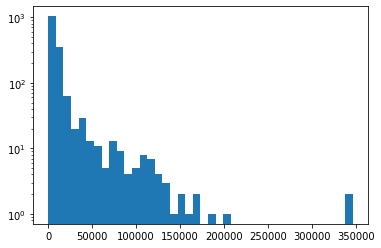

In [4]:
# overview Japanese corpus on histgram
import matplotlib.pyplot as plt

corpus_tokenized_ja = load_log('20200411T092421Z','corpus_tokenized_ja.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

In [5]:
#check the number of the corpus
len(corpus_tokenized_ja)

1589

## vectorize

For document vectorization, we use [SCDV](https://arxiv.org/pdf/1612.06778.pdf).  
Refer to the blogs \[[1](https://qiita.com/fufufukakaka/items/a7316273908a7c400868), [2](https://qiita.com/nishiba/items/40449df6c931cca38abe)\] for Japanese explanatinon.

In [6]:
# get word vectors by gensim
def build_word_embedding_vectors(corpus_tokenized, word2vec_parameters):
    model = word2vec.Word2Vec(corpus_tokenized, **word2vec_parameters)
    return model, model.wv.vectors, model.wv.index2word

In [27]:
# culster word vectors by GMM
def culster_embedding_vectors(word_embeddings, gmm_parameters) -> np.ndarray:
    X = word_embeddings
    gm = GaussianMixture(**gmm_parameters)
    gm.fit(X)
    return gm.predict_proba(X)

In [8]:
# TF-IDF takes 20 min
# Use for Japanese
from collections import Counter
from itertools import chain, repeat
from operator import countOf


def build_tfidf_selfmade(corpus, vocab):
    countup = lambda doc: list(map(countOf, repeat(doc), vocab))
    tf = np.array(list(map(countup, corpus)))
    idf = np.log(len(corpus) / (tf > 0).sum(axis=0)) + 1
    return tf, idf, tf*idf

In [9]:
# TF-IDF
# cannot be used for JApanese
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf_sklearn(corpus_tokenized, vocab):
    tfv = TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b', strip_accents='unicode', dtype=np.float64)
    tfv.fit(list(map(' '.join, corpus_tokenized)))
    feature_names = tfv.get_feature_names()
    idf = tfv._tfidf.idf_
    print(len(feature_names), len(idf), len(vocab))
    return np.fromiter(map(dict(zip(feature_names, idf)).get, vocab), dtype='f8')    

In [10]:
def build_word_topic_vector(word_embedding_vectors, word_cluster_probabilities, idf_vector):
    wcv = np.einsum('ij,ik->ijk', word_embedding_vectors, word_cluster_probabilities).reshape(word_embedding_vectors.shape[0], -1)
    return np.einsum('i,ij->ij', idf_vector, wcv)

In [15]:
# document vectors
def count(i=0):
    while True:
        yield i
        i+=1

def normalize_document_vectors(dv: np.ndarray) -> np.ndarray:
    dv_sum = np.square(dv).sum(axis=1)
    dv_l2norm = np.sqrt(dv_sum)
    return np.einsum('ij,i->ij', dv, 1.0/dv_l2norm)

def build_document_vectors(vocabulary, corpus_tokenized, word_topic_vectors):
    vocabulary_idx_map = dict(zip(vocabulary, count()))
    
    document_vecotrs = []
    for doc in corpus_tokenized:
        doc_idx = list(filter(lambda idx: idx is not None, map(vocabulary_idx_map.get, doc)))
        document_vecotrs.append(np.einsum('ij->j',word_topic_vectors[doc_idx]))
    
    return normalize_document_vectors(np.array(document_vecotrs))

In [16]:
# SCDV
def make_sparse(document_vectors, param):
    t = 0.5 * (np.abs(np.min(document_vectors, axis=1).mean()) + np.abs(np.max(document_vectors, axis=1).mean()))
    sparsity_threshold = param * t
    mask = np.abs(document_vectors) < sparsity_threshold
    return np.where(mask, 0.0, document_vectors)

In [18]:
corpus_tokenized = corpus_tokenized_ja

In [42]:
word2vec_parameters = {
    'size':200,   # Word vector dimensionality
    'min_count':20,    # Minimum word count
    'workers':40,    # Number of threads to run in parallel
    'window':10,    # Context window size
    'sample':1e-3,    # Downsample setting for frequent words
    'hs':0,
    'sg':1,
    'negative':10,
    'iter':25,
    'seed':1
}

word_embedding_model, word_embedding_vectors, vocabulary = build_word_embedding_vectors(corpus_tokenized, word2vec_parameters)

In [45]:
logger = initialize_logger()
logger('word_embedding_vectors.npy', word_embedding_vectors)
logger('vocabulary.json', vocabulary)
word_embedding_model.save('word_embedding_model.model')

In [17]:
timestamp = '20200411T140408Z'
word_embedding_vectors = load_log(timestamp,'word_embedding_vectors.npy')
vocabulary = load_log(timestamp,'vocabulary.json')
word_embedding_vectors.shape, len(vocabulary)

((30639, 200), 30639)

In [47]:
gmm_parameters = {
    'n_components':60,
    'random_state':42,
    'covariance_type':'tied',
    'init_params':'kmeans',
    'max_iter':50
}

word_cluster_probability_matrix = culster_embedding_vectors(word_embedding_vectors, gmm_parameters)

In [48]:
logger('word_cluster_probabilities.npy', word_cluster_probability_matrix)

In [20]:
timestamp = '20200411T140408Z'
word_cluster_probability_matrix = load_log(timestamp,'word_cluster_probabilities.npy')
word_cluster_probability_matrix.shape

(30639, 60)

In [21]:
tf, idf, tfidf = build_tfidf_selfmade(corpus_tokenized, vocabulary)

In [22]:
logger = initialize_logger()
logger('tf_matrix.npy', tf)
logger('idf_vector.npy', idf)
logger('tfidf_matrix.npy', tfidf)

In [23]:
timestamp = '20200412T080115Z'
tf_matrix = load_log(timestamp,'tf_matrix.npy')
idf_vector = load_log(timestamp,'idf_vector.npy')
tfidf_matrix = load_log(timestamp,'tfidf_matrix.npy')
tf_matrix.shape, idf_vector.shape, tfidf_matrix.shape

((1589, 30639), (30639,), (1589, 30639))

In [ ]:
word_topic_vectors = build_word_topic_vector(word_embedding_vectors, word_cluster_probability_matrix, idf_vector)

In [24]:
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja, word_topic_vectors)
param = 0.04
scdv = make_sparse(document_vectors, param)

In [25]:
# logger = initialize_logger()
logger('scdv.npy', scdv)

In [26]:
timestamp = '20200412T080115Z'
scdv = load_log(timestamp,'scdv.npy')
scdv.shape

(1589, 12000)

## Validate with SCDV

In [70]:
X = scdv
y = y_train
X.shape, y.shape

((1589, 12000), (1589,))

In [71]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [73]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [74]:
accuracy_train

array([1., 1., 1., 1., 1.])

In [75]:
accuracy_test

array([0.9014695 , 0.91936822, 0.88398   , 0.88541975, 0.94583701])

In [76]:
np.average(accuracy_test)

0.9072148963964748

## Validate with TF-IDF

In [46]:
X = tfidf_matrix
X.shape, y.shape

((1589, 30639), (1589,))

In [47]:
def kfold_splitter(n_samples, n_folds, rng):
    shuffled_fold_indices = rng.permutation(np.arange(n_samples) % n_folds)
    for k in range(n_folds):
        mask = shuffled_fold_indices == k
        yield tuple(map(np.flatnonzero, (mask, ~mask)))

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

clf = RandomForestClassifier(random_state=0, max_depth=None, max_features='sqrt',
                             class_weight='balanced', n_jobs=-1)

In [49]:
n_fold = 5
n_samples = y.size
rng = np.random.RandomState(42)

accuracy_train = []
accuracy_test = []

for test_idx, train_idx in kfold_splitter(n_samples, n_fold, rng):
    y_test = y[test_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    X_train = X[train_idx]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)
    bas = balanced_accuracy_score(y_train, y_pred)
    accuracy_train.append(bas)
    
    y_pred = clf.predict(X_test)
    bas = balanced_accuracy_score(y_test, y_pred)
    accuracy_test.append(bas)

accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

In [50]:
accuracy_train

array([1., 1., 1., 1., 1.])

In [51]:
accuracy_test

array([0.88501032, 0.88269083, 0.85700199, 0.88438033, 0.87580956])

In [52]:
np.average(accuracy_test)

0.8769786074675944

## predict test data

### preprocess

In [54]:
import glob, os


test_files = glob.glob('../data/aozora_datasets_min/test_datasets/*.txt')
len(test_files)

532

In [60]:
data_test = pd.DataFrame(columns=['filename','tokens'])
data_test['filename'] = list(map(os.path.basename, test_files))
data_test['tokens'] = [tokenize_ja(path) for path in test_files]
data_test.head(15)

,filename,tokens
0,54740.txt,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 日本一, の, 面白い, 話, が,..."
1,56321.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, 捕物, 小説, という, もの, を..."
2,56201.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, おや, 八, 五, 郎, 親分, も..."
3,51417.txt,"[先刻, 御, 面, 遠い, 遠い, に, 倒, の, 注記, 御, 頼, 申, 上, 候,..."
4,49540.txt,"[何, と, いう, て, も, この, 頃, は, 読書, 子, に, 取る, て, は,..."
5,46139.txt,"[府中, ふち, ゅう, すみません, ねえ, これ, じゃ, 冥利, に, つきる, よう..."
6,1711.txt,"[第, 一, 章, 道徳, に関する, 通俗, 常識, 的, 観念, 道徳, の, 問題, ..."
7,3578.txt,"[湯島, の, 境内, 婦, 系図, 戯曲, 一齣, ここ, から, １, 字, 下げ, 歌..."
8,51959.txt,"[参上, 仕る, 候, よい, ｜, 被, 二, 仰る, 聞, 一, お, ほする, きかす..."
9,56210.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, 江戸, の, 大通, だい, つう,..."


In [62]:
data_test.loc[data_test.isnull().any(axis=1)]

,filename,tokens


In [63]:
# dump preprocessed data
corpus_tokenized_ja_test = data_test['tokens'].tolist()
logger('corpus_tokenized_ja_test.json', corpus_tokenized_ja_test)

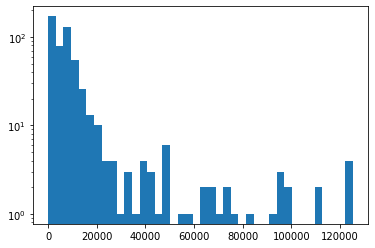

In [64]:
# overview japanese corpus
import matplotlib.pyplot as plt

timestamp = '20200412T080115Z'
corpus_tokenized_ja_test = load_log(timestamp,'corpus_tokenized_ja_test.json')
len_tokens_ja = list(map(len, corpus_tokenized_ja_test))
plt.hist(len_tokens_ja, bins=40)
plt.yscale('log')

### vectorize test corpus

In [65]:
# scdv ignoring unknown tokens
document_vectors = build_document_vectors(vocabulary, corpus_tokenized_ja_test, word_topic_vectors)
param = 0.04
scdv_ignr_unk = make_sparse(document_vectors, param)
scdv_ignr_unk.shape

(532, 12000)

### predict test data

In [77]:
X_test = scdv_ignr_unk
X_test.shape

(532, 12000)

In [78]:
y_pred_proba = clf.predict_proba(X_test)

In [82]:
y_pred_proba.shape

(532, 17)

(array([  4.,  10.,   6.,  18.,   6.,  19.,  11.,  13.,  17.,  15.,  16.,
         18.,  19.,  12.,  15.,  18.,  23.,  35.,  54., 203.]),
 array([0.13  , 0.1735, 0.217 , 0.2605, 0.304 , 0.3475, 0.391 , 0.4345,
        0.478 , 0.5215, 0.565 , 0.6085, 0.652 , 0.6955, 0.739 , 0.7825,
        0.826 , 0.8695, 0.913 , 0.9565, 1.    ]),
 <a list of 20 Patch objects>)

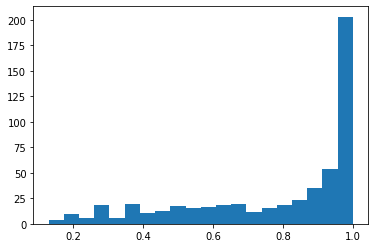

In [79]:
plt.hist(list(map(max, y_pred_proba)), bins=20)
# plt.hist(y_pred_proba.max(axis=1), bins=20)

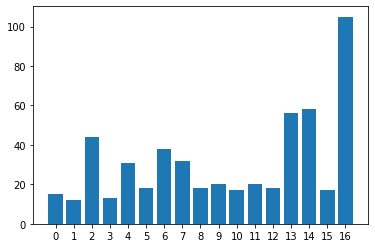

In [80]:
y_pred = y_pred_proba.argmax(axis=1)
u, counts = np.unique(y_pred, return_counts=True)
plt.bar(u, counts)
plt.xticks(u);

### set authors

In [95]:
label_author_map = dict([(v,k) for k,v in author_label_map.items()])
author_pred = list(map(label_author_map.get, y_pred))

In [89]:
data_test.assign(predicted_author = author_pred)

,filename,tokens,predicted_author
0,54740.txt,"[９, 字, 下げ, 一, 一, は, 中, 見出し, 日本一, の, 面白い, 話, が,...",野村 胡堂
1,56321.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, 捕物, 小説, という, もの, を...",野村 胡堂
2,56201.txt,"[５, 字, 下げ, 一, 一, は, 中, 見出し, おや, 八, 五, 郎, 親分, も...",野村 胡堂
3,51417.txt,"[先刻, 御, 面, 遠い, 遠い, に, 倒, の, 注記, 御, 頼, 申, 上, 候,...",坂本 竜馬
4,49540.txt,"[何, と, いう, て, も, この, 頃, は, 読書, 子, に, 取る, て, は,...",岡本 綺堂
...,...,...,...
527,476.txt,"[一, 次郎左衛門, じ, ろ, ざえもん, が, 野, 州, や, しゅう, 佐野, の,...",岡本 綺堂
528,57308.txt,"[今年, の, 六月, 本土, 爆撃, が, いよいよ, 苛烈, に, なる, て, 東京,...",中谷 宇吉郎
529,1710.txt,"[序, 思想, という, もの, は, その, 持ち主, の, 身, に, つく, ば, そ...",戸坂 潤
530,53489.txt,"[もう, 十, 年, 以上, も, 前, の, こと, だ, ある, が, まだ, 私, が...",中谷 宇吉郎


In [90]:
filename_author_map_test = dict(zip(data_test['filename'], data_test['predicted_author']))

In [107]:
import pandas as pd

input_test='../data/aozora_datasets_min/test_author_novel.csv'
df_test = pd.read_csv(input_test)
df_test['author'] = list(map(filename_author_map_test.get, df_test['filename']))
df_test['author_id'] = list(map(\
            dict(zip(df_train['author_name'], df_train['author_id'])).get, df_test['author']\
            ))
df_test

,novel_id,filename,author,author_id
0,2198,2198.txt,若山 牧水,162
1,2213,2213.txt,若山 牧水,162
2,2627,2627.txt,若山 牧水,162
3,2618,2618.txt,石川 啄木,153
4,2621,2621.txt,石川 啄木,153
...,...,...,...,...
527,48367,48367.txt,岡本 綺堂,82
528,48163,48163.txt,石川 啄木,153
529,48151,48151.txt,折口 信夫,933
530,48152,48152.txt,坂本 竜馬,908


In [126]:
df_test.to_csv('../data/test_author_novel_predicted.csv', index=False)

### check predicted results

In [109]:
df_test.loc[200,:]

novel_id         55744
filename     55744.txt
author           野村 胡堂
author_id         1670
Name: 200, dtype: object

In [110]:
df_test.index

RangeIndex(start=0, stop=532, step=1)

In [111]:
rng = np.random.RandomState(0)

In [112]:
df_test.loc[rng.choice(df_test.index,10),:]

,novel_id,filename,author,author_id
192,54587,54587.txt,野村 胡堂,1670
359,24436,24436.txt,折口 信夫,933
9,2630,2630.txt,若山 牧水,162
277,46197,46197.txt,高村 光雲,270
70,47985,47985.txt,正岡 子規,305
472,50786,50786.txt,泉 鏡花,50
396,49554,49554.txt,泉 鏡花,50
314,51789,51789.txt,坂本 竜馬,908
486,4997,4997.txt,泉 鏡花,50
87,46136,46136.txt,久生 十蘭,1224


In [124]:
path_test_samples = df_test.filename.sample(1, replace=False)
path_test_samples

181    57200.txt
Name: filename, dtype: object

In [125]:
list(map(filename_author_map_test.get, path_test_samples))

['野村 胡堂']

In [120]:
path = '56314.txt'
path_test = '../data/aozora_datasets_min/test_datasets/{}'.format(path)
with open(path_test) as f:
    print(f.read())


［＃５字下げ］一［＃「一」は中見出し］

　人間業では盗めそうもない物を盗んで、遅くとも三日以内には、元の持主に返すという不思議な盗賊が、江戸中を疾風のごとく荒し廻りました。
「平次、御奉行｜朝倉石見守《あさくらいわみのかみ》様から厳《きつ》い御達しだ、――近頃府内を騒がす盗賊、盗んだ品を返せば罪はないようなものではあるが、あまりと言えばお上の御威光を蔑《ないがし》ろにする仕打だ。明日とも言わず、からめ取って来い――とおっしゃる、何とか良い工夫はあるまいか」
　南町奉行付、与力筆頭《よりきひっとう》笹野新三郎、自分とは身分が違いながら、親身のように思っている捕物の名人銭形の平次に、こう打ち明けて頼み込みました。
「ヘエ、――私も考えないじゃございません。盗んですぐ返すというやり方が第一気に入りません。恋の付け文、貧の盗みと言うくらいで、食うに困っての盗みなら、悪いながらも可哀想とも思います。盗んだ品を翌《あく》る日返すのは、盗みを道楽にしている人でなきゃア、私どもを翻弄《からか》っているに相違ございません、何とかしてあの野郎をフン捕まえなきゃア、銭形の平次も世間へ顔向けがなりません」
　若い平次は、日頃の温厚な様子にも似ず、ツイ拳固《げんこ》で膝を叩きながら、縁側の敷居際までにじり［＃「にじり」に傍点］寄ります。
「お前がその気なら、遠からず捉《つか》まえられるだろう――少しは心当りがあるだろうな」
「恥ずかしながら、何の手掛りもございません」
「女泥棒だというが、本当だろうな」
「それも当にはなりません。盗んだ品を返しに来るのは、目の醒《さ》めるような美しい新造《しんぞ》だって言いますが、それが盗むにしちゃ、手際が良すぎます」
「と言うと」
「鍵や錠を苦もなく外すのはともかくとして一丈も一丈二尺もある塀を飛越したり、長押《なげし》を踏んで座敷へ忍び込んだり、とても女や子供に出来る芸当じゃございません」
「フーム」
　笹野新三郎も、銭形の平次も、近頃人も無気《なげ》に出没する怪盗――風のごとく去来するから世間では風太郎《かぜたろう》と言っておりますが――には全く手を焼いてしまいました。
「たった一つ、仕残した手段《てだて》がございます」
「どんな事だ」
「謀事《はかりごと》は密なるを要すって申しましょう。もう二三日お待ち下さいまし」
「ハッハハハハハ、平次は思いの

In [121]:
filenametrain='56315.txt'
path_test = '../data/aozora_datasets_min/train_datasets/{}'.format(filenametrain)
with open(path_test) as f:
    print(f.read())


［＃５字下げ］一［＃「一」は中見出し］

「八、たいそう手前《てめえ》は粋になったな」
「からかっちゃいけません、親分」
　八五郎のガラッ八は、あわてて、膝《ひざ》っ小僧を隠しました。柄にない狭い単衣《ひとえ》、尻をまくるには便利ですが、真面目に坐り直すと、帆立《ほった》て尻《じり》にならなければ、どう工面をしても膝っ小僧がハミ出します。
「隠すな、八、ネタはちゃんと挙がってるぜ」
　銭形平次は構わずに続けました。
「へッ、へッ、どの口のネタで？」
「いやな野郎だな、顎《あご》なんか撫《な》でて、――近頃手前、遠吠えの稽古《けいこ》をするってえ話じゃないか」
「遠吠えは情けねえ。誰がそんな事を親分に言い付けたんで」
　ガラッ八は少しばかり意気込みました。
「手前の伯母さんだよ。――今朝お勝手口へ顔を出して、お静に愚痴を聞かせていたぜ――酒や女の道楽と違って、若い者の稽古所入りが悪いではありませんが、家へ帰って来て唸《うな》られると気が滅入ります。糠味噌《ぬかみそ》は蓋《ふた》に仔細《しさい》はございませんが、あんな調子っ外れの遠吠えを聞かされたら、どんな気の強い娘も寄り付かないだろうと思うと、可哀想でなりません。御存じの通り、あれはまだ独り者ですから――だとさ。どうだい八、伯母さんは苦労人だろう。あんまり心配さしちゃならねえよ」
「チェッ、憚《はばか》りながら娘っ子｜除《よ》けの禁呪《まじない》に小唄をやっているんだ。心配して貰いたくねえ」
　ガラッ八はそう言いながらも、耳の後ろをポリポリ掻いております。
「そうだろうとも、だから俺は言ってやってよ。――伯母さんの若い時と違って、この節はあんなのが流行《はや》るんだ――てね、小唄一つ歌うんだって、鼻っ先や喉《のど》で転がすんじゃねえ。八の野郎は胆っ玉で歌うに違《ちげ》えねえ。――」
　銭形平次に悪気があるわけでなかったのですが、伯母の口吻《こうふん》から察して、ガラッ八の八五郎が小唄の師匠に気がありそうにも取れたので、それとはなしに脈を引いて、意見をするものなら、今のうちに意見をしようと思ったのです。
「親分、本当のことを言うと、こいつにはワケがありますよ」
「そうだろうとも。二日も行かなきゃ、師匠の小唄お政《まさ》が、迎えをよこすほどだって言うから、ワケだって大ありだろうよ」
「嫌だね。伯母さんが、そんな事までブ

In [123]:
df_train[df_train.filename == '56315.txt']

,author_id,author_name,novel_id,novel_title,filename
394,1670,野村 胡堂,56315,銭形平次捕物控,56315.txt
